# E-commerce RFM Customer Segmentation

This notebook aims at performing customer segmentation base on RFM metrics and KMeans model  
RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait  

In this project, we use E-commerce dataset that contains purchase transactions of over 4000 customers within a year (Dec-2010 - Dec-2011)  


<h1>Table of contents</h1>

<head>
  <title>Title of the document</title>
  <style>
    ol {
      counter-reset: item;
    }
    li {
      display: block;
    }
    li:before {
      content: counters(item, ".") " ";
      counter-increment: item;
    }
  </style>
</head>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#data_u_c">Data Understanding and Cleaning</a>
        <ol>
            <li><a href="#data_understanding">Data Understanding</a></li>
            <li><a href="#data_cleaning">Data Cleaning</a></li>
        </ol></li>
        <li><a href="#eda">Exploratory Data Analysis (EDA)</a>
        <ol>
            <li><a href="#stockcode_n_des">StockCode and Description</a></li>
            <li><a href="#country">Country</a></li>
            <li><a href="#invoice_date">InvoiceDate</a></li>
            <li><a href="#quantity_price">Quantity and UnitPrice</a></li>
        </ol></li>
        <li><a href="#modeling">Modeling</a>
        <ol>
            <li><a href="#data_transformation">Data transformation</a></li>
            <li><a href="#data_normalization">Data Normalization</a></li>
            <li><a href="#data_modeling">Data Modeling</a></li>
        </ol></li>
    </ol>
</div>
<hr>

## 1. Data Understanding and Data Cleaning
<a id="data_u_c"></a>

### 1.1 Data Understanding
<a id="data_understanding"></a>

Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

import datetime as dt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6.75)

In [2]:
df = pd.read_csv("./input/data.csv",
                 encoding = 'unicode-escape',
                 dtype={'CustomerID': str, 'InvoiceDate': str,},
                 parse_dates = ['InvoiceDate'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


### Variable Description

- **InvoiceNo**: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product code that consists 5 digits.
- **Description**: Product name.
- **Quantity**: The quantities of each product per transaction.
- **InvoiceDate**: Represents the day and time when each transaction was generated.
- **UnitPrice**: Product price per unit.
- **CustomerID**: Customer number that consists 5 digits. Each customer has a unique customer ID.
- **Country**: Name of the country where each customer resides.

### 1.2 Data Cleaning
<a id="data_cleaning"></a>

#### 1.2.1 Current features

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

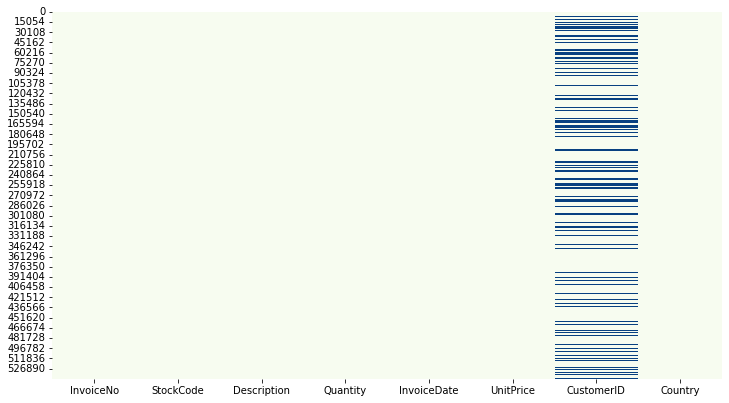

In [5]:
sns.heatmap(df.isnull(), cbar=False, cmap='GnBu')

Let's look at some sample records that has null CustomerID

In [6]:
df.loc[df.CustomerID.isnull()].sample(10, random_state=27)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
53032,540821,20754,RETROSPOT RED WASHING UP GLOVES,1,2011-01-11 13:16:00,4.21,NaN,United Kingdom
287687,562113,20664,TROPICAL HOLIDAY PURSE,1,2011-08-02 16:11:00,2.46,NaN,United Kingdom
52817,540821,22348,TEA BAG PLATE RED RETROSPOT,1,2011-01-11 13:16:00,1.66,NaN,United Kingdom
220396,556188,20868,SILVER FABRIC MIRROR,5,2011-06-09 11:49:00,0.39,NaN,United Kingdom
13754,537434,22973,CHILDREN'S CIRCUS PARADE MUG,1,2010-12-06 16:57:00,3.36,NaN,United Kingdom
341873,566787,23339,EGG FRYING PAN BLUE,1,2011-09-15 10:31:00,4.13,NaN,United Kingdom
42898,540026,22258,FELT FARM ANIMAL RABBIT,9,2011-01-04 13:25:00,0.85,NaN,United Kingdom
141228,548504,21931,JUMBO STORAGE BAG SUKI,4,2011-03-31 14:33:00,4.13,NaN,United Kingdom
539417,581439,21126,SET OF 6 GIRLS CELEBRATION CANDLES,2,2011-12-08 16:30:00,1.25,NaN,United Kingdom
279862,561369,21918,SET 12 KIDS COLOUR CHALK STICKS,1,2011-07-26 16:21:00,0.83,NaN,United Kingdom


Can we impute it by look for InvoiceNo within dataset that CustomerID is not null?
Let's find out

In [7]:
df.loc[df.CustomerID.isnull(), ['InvoiceNo']].isin(df.loc[~df.CustomerID.isnull(), ['InvoiceNo']]).value_counts()

InvoiceNo
False        135080
dtype: int64

Non of InvoiceNo with null CustomerID were found in the rest of dataset.  
Without CustomerID, we can not perform customer segmentation and further customer analysis. So we drop records with null CustomerID

In [8]:
df.dropna(axis=0, subset=['CustomerID'], inplace=True)

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

After drop null CustomerID, remaining data has no null values

In this dataset, cancellation transactions is the one with negative quantity and InvoiceNo start with letter 'C'  
We need to drop irrelevant transactions, that is the cancellations that not corresponding with any transaction in this dataset  

In [10]:
df.loc[df.Quantity < 0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [11]:
df.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

We can see, StockCode = 'D' indicate for Discount that customer received.  
Cancellation and discount usually take place after the origin transaction date. So, for cancellation and discount occurred in the very first day (2010-12-01) of this dataset, we will exclude them, as they indicate previous transaction that not included

In [12]:
df.drop(axis=0, index=df.loc[(df.InvoiceDate < dt.datetime(2010,12,2)) & 
                             (df.Quantity < 0)].index, inplace=True)

We need to keep index to find keep/remove records much easier

In [13]:
df_cancel = df.loc[(df.Quantity < 0) & (df.StockCode != 'D')].copy()
df_cancel['origin_index'] = df_cancel.index

Now, we map cancellations with its origin transactions. If we can not find its origin, we will drop it

In [14]:
new_df = pd.merge(df_cancel, df.loc[df.Quantity > 0],
                  how='left',
                  left_on=['CustomerID', 'StockCode', 'UnitPrice'],
                  right_on=['CustomerID', 'StockCode', 'UnitPrice'])
new_df.head(2)

,InvoiceNo_x,StockCode,Description_x,Quantity_x,InvoiceDate_x,UnitPrice,CustomerID,Country_x,origin_index,InvoiceNo_y,Description_y,Quantity_y,InvoiceDate_y,Country_y
0,C536606,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-2,2010-12-02 09:10:00,2.95,14092,United Kingdom,3170,539283,SET/5 RED RETROSPOT LID GLASS BOWLS,6.0,2010-12-16 15:47:00,United Kingdom
1,C536606,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-2,2010-12-02 09:10:00,2.95,14092,United Kingdom,3170,546640,SET/5 RED RETROSPOT LID GLASS BOWLS,6.0,2011-03-15 12:56:00,United Kingdom


In [15]:
keep = new_df.loc[(new_df.InvoiceDate_y <= new_df.InvoiceDate_x) &
                  (-new_df.Quantity_x <= new_df.Quantity_y)
                  , ['origin_index']].drop_duplicates()
remove_index = df_cancel.loc[~df_cancel.index.isin(keep.origin_index)].index
remove_index.shape

(1630,)

In [16]:
df.drop(index=remove_index, inplace=True)

#### 1.2.2 Added feature: TotalPrice

In [17]:
df[['TotalPrice']] = pd.DataFrame(df.Quantity * df.UnitPrice)

In [18]:
df.loc[df.TotalPrice > 5000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,United Kingdom,6539.40
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom,6539.40
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.00
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,United Kingdom,7144.72
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.60


In [19]:
df.TotalPrice.describe()

count    405173.000000
mean         20.847463
std         423.205031
min     -168469.600000
25%           4.250000
50%          11.250000
75%          19.500000
max      168469.600000
Name: TotalPrice, dtype: float64

We will see the quantile in more detail

In [20]:
df.TotalPrice.quantile(np.linspace(0,1,21))

0.00   -168469.60
0.05         0.85
0.10         1.65
0.15         2.50
0.20         3.30
0.25         4.25
0.30         5.04
0.35         6.75
0.40         8.40
0.45        10.00
0.50        11.25
0.55        13.50
0.60        15.00
0.65        15.90
0.70        17.40
0.75        19.50
0.80        20.80
0.85        25.50
0.90        35.40
0.95        67.50
1.00    168469.60
Name: TotalPrice, dtype: float64

Outliers need to be replace, as it could affect our model. I sugguest to replace them with threshold at 0.01 and 0.99 quantile

In [21]:
df_initial = df.copy()
up_limit = df.TotalPrice.quantile(0.99)
low_limit = df.TotalPrice.quantile(0.01)
df.loc[df.TotalPrice > up_limit, ['TotalPrice']] = up_limit
df.loc[df.TotalPrice < low_limit, ['TotalPrice']] = low_limit

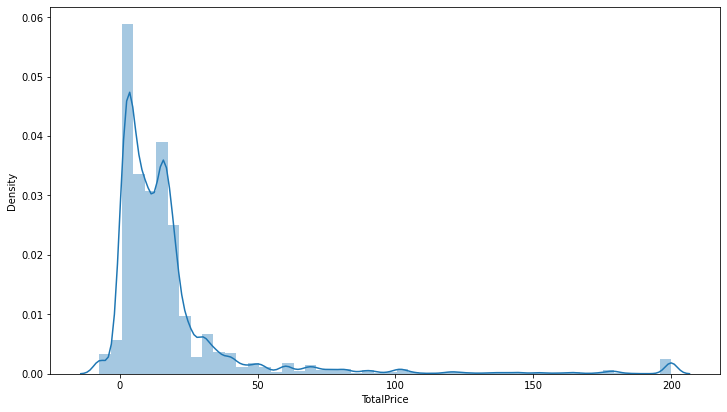

In [22]:
sns.distplot(df.TotalPrice)
plt.show()

To reduce skewness, I will use another upper threshold for TotalPrice at $100

In [23]:
df.loc[df.TotalPrice > 100, ['TotalPrice']] = 100

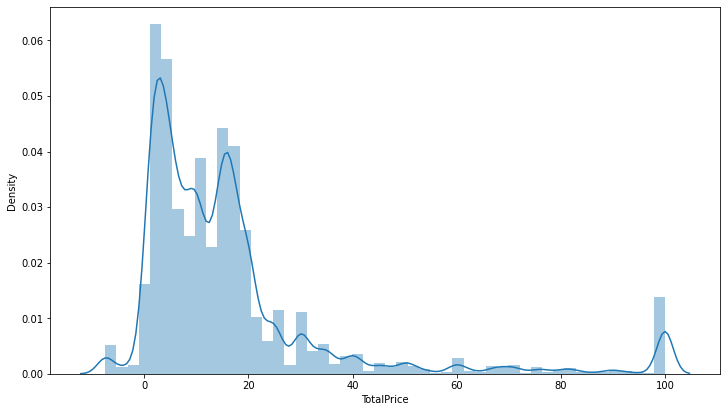

In [24]:
sns.distplot(df.TotalPrice)
plt.show()

#### 1.2.3 Calculate Recency, Frequency, Monetary

In [25]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [26]:
today_date = dt.datetime(2011,12,10).date()
df_RFM = df.groupby(['CustomerID'], as_index=False).agg({'InvoiceDate': lambda x: (today_date - x.max().to_pydatetime().date()).days,
                                          'InvoiceNo': lambda x: x.nunique(),
                                          'TotalPrice': lambda x: x.sum()})
df_RFM.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df_RFM.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,92.50
1,12347,3,7,4148.00
2,12348,76,4,1562.84
3,12349,19,1,1557.55
4,12350,311,1,334.40


In [27]:
df_RFM.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.561420,4.981102,1564.103801
std,99.638404,9.136540,4538.967035
min,1.000000,1.000000,0.000000
25%,17.000000,1.000000,289.295000
50%,50.000000,3.000000,635.410000
75%,141.000000,5.000000,1534.995000
max,374.000000,246.000000,156863.760000


Monetary has a big std, a mean is 2.5 times larger than median  
Let's reduce Monetary max value to quantile 0.99

In [28]:
up_limit = df_RFM.Monetary.quantile(0.99)
df_RFM.loc[df_RFM.Monetary > up_limit, ['Monetary']] = up_limit

In [29]:
df_RFM.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.561420,4.981102,1368.169094
std,99.638404,9.136540,2044.360931
min,1.000000,1.000000,0.000000
25%,17.000000,1.000000,289.295000
50%,50.000000,3.000000,635.410000
75%,141.000000,5.000000,1534.995000
max,374.000000,246.000000,12711.737200


## 2. Exploratory Data Analysis (EDA)
<a id="eda"></a>

In [30]:
print("After cleaning, our dataset has {} records and {} fields".format(df.shape[0], df.shape[1]))

After cleaning, our dataset has 405173 records and 9 fields


In [31]:
df[['Country', 'StockCode', 'Description', 'CustomerID', 'InvoiceDate', 'InvoiceNo']].nunique().sort_values()

Country           37
StockCode       3666
Description     3878
CustomerID      4339
InvoiceDate    19978
InvoiceNo      21613
dtype: int64

#### 2.1 StockCode and Description
<a id="stockcode_n_des"></a>

Number of unique StockCode do not equivalent with Description  
Let's find out which StockCode have more than one Description

In [32]:
df_temp = df.groupby(['StockCode', 'Description'], as_index=False)[['CustomerID']]\
            .count().rename(columns={'CustomerID':'number_of_occur'})
df_temp.loc[df_temp.StockCode.duplicated(keep=False)].head(10)

,StockCode,Description,number_of_occur
42,16156L,WRAP CAROUSEL,14
43,16156L,"WRAP, CAROUSEL",4
101,17107D,FLOWER FAIRY 5 DRAWER LINERS,21
102,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,1
103,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",25
121,20622,VIP PASSPORT COVER,11
122,20622,VIPPASSPORT COVER,22
174,20725,LUNCH BAG RED RETROSPOT,1353
175,20725,LUNCH BAG RED SPOTTY,1
267,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,808


So with the same StockCode, Descriptions are a little bit differ. It is not affect as we do not analyze Description (like find most occurred keywords or categorized them)

In previous section, we can see that some of StockCode represent for a special transactions. They usually start with a letter

In [33]:
spec_transact = df.loc[df.StockCode.str.contains('^[a-zA-Z]+', regex=True), ['StockCode', 'Description', 'CustomerID']]\
                        .groupby(['StockCode', 'Description'], as_index=False).count()\
                        .rename(columns={'CustomerID': 'num_of_occur'})
spec_transact

,StockCode,Description,num_of_occur
0,BANK CHARGES,Bank Charges,12
1,C2,CARRIAGE,134
2,D,Discount,76
3,DOT,DOTCOM POSTAGE,16
4,M,Manual,317
5,PADS,PADS TO MATCH ALL CUSHIONS,4
6,POST,POSTAGE,1133


In [34]:
df.loc[(df.StockCode.isin(spec_transact.StockCode)) & (df.Quantity < 0)]['StockCode'].unique()

array(['D', 'POST', 'C2', 'M'], dtype=object)

In [35]:
df.loc[(df.StockCode.isin(spec_transact.StockCode)) & (df.Quantity > 0)]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

POSTAGE: can have both negative and positive Quantity  
Discount: negative  
Others: positive

#### 2.2 Country
<a id="country"></a>

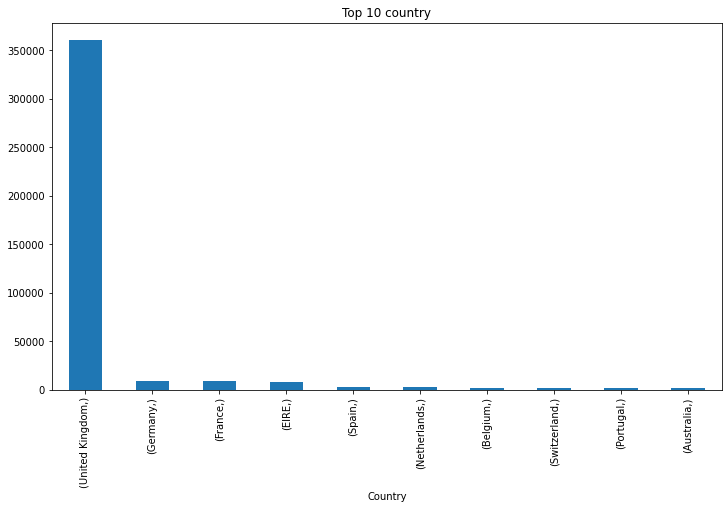

In [36]:
df[['Country']].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 country")
plt.show()

Most of out record (88.9%) originate from UK customers, and the remaining belongs Europe, Asian, South America

#### 2.3 InvoiceDate
<a id="invoice_date"></a>

In [37]:
df.InvoiceDate.describe()

count                  405173
unique                  19978
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

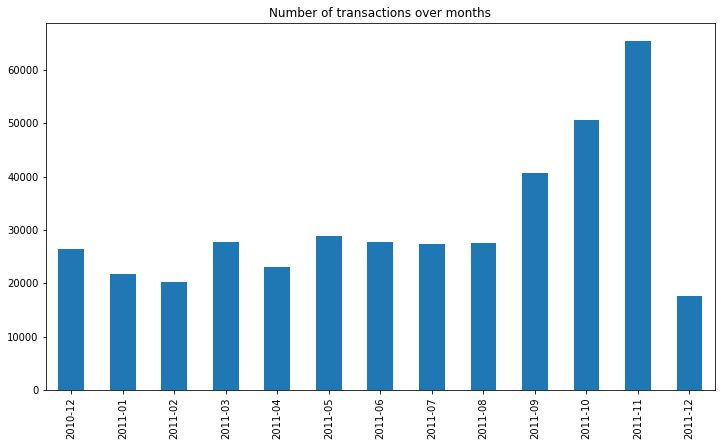

In [38]:
df.InvoiceDate.dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Number of transactions over months')
plt.show()

There is no significant difference in transaction volume before September-2011  
But from September-2011 to last of 2011, transaction volume increased sharply  
Notice that our data end at 9th Dec 2011, but it reached a significant volume. For the whole December, number of transactions must high as New Year holiday's coming

#### 2.4 Quantity and UnitPrice
<a id="quantity_price"></a>

In [39]:
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,405173.000000,405173.000000
mean,12.175165,3.186581
std,248.735532,23.056639
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


<AxesSubplot:>

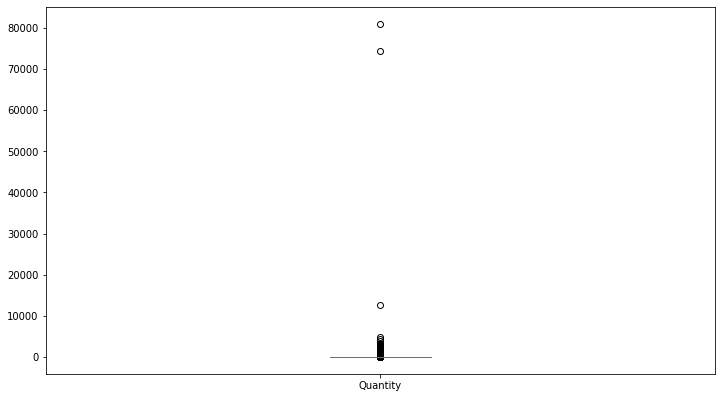

In [40]:
df.loc[(df.Quantity > 0), ['Quantity']].plot(kind='box')

75% values of Quantity is below 12, but the max value reach nearly 81k! Box plot show a lot of outliers

UnitPrice has the same situation with Quantity, while most values (97%) below $10, some others can reach $8k

## 3. Modeling
<a id="modeling"></a>

### 3.1 Data transformation
<a id="data_transformation"></a>

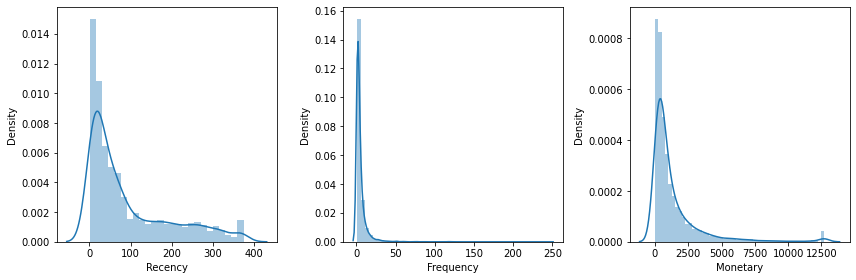

In [41]:
fix, ax = plt.subplots(1, 3, figsize=(12,4))
sns.distplot(df_RFM.Recency, ax = ax[0])
sns.distplot(df_RFM.Frequency, ax = ax[1])
sns.distplot(df_RFM.Monetary, ax = ax[2])
plt.tight_layout()
plt.show()

As we see on the charts, all our metrics are right-skewed.  
We need use find the best way to reduce the skewness, out of log, square root, cubic root, boxcox

In [42]:
# from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots (2, 2, figsize = (5,5))
    sns.distplot(df_RFM[x], ax=ax[0,0])
    sns.distplot(np.log(df_RFM[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_RFM[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_RFM[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    print(df_RFM[x].skew().round(2), end='   ')
    print(np.log(df_RFM[x]).skew().round(2), end='\n\n')
    print(np.sqrt(df_RFM[x]).skew().round(2), end='   ')
    print(pd.Series(stats.boxcox(df_RFM[x])[0]).skew().round(2))

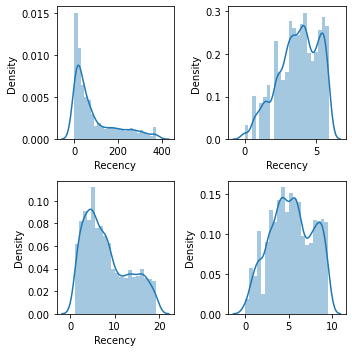

1.26   -0.44

0.61   -0.06


In [43]:
analyze_skewness('Recency')

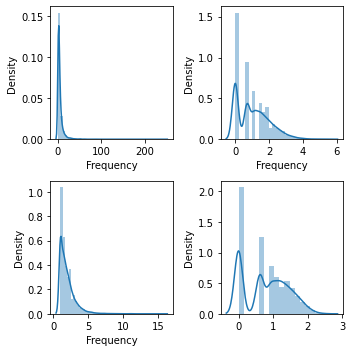

11.61   0.69

2.91   0.11


In [44]:
analyze_skewness('Frequency')

For both Recency and Frequency, boxcox method have the best results with skewness very close to 0

For Monetary, we use cubic root because it's values are float and can not apply above method

In [45]:
print('Cubic root skewness score: {}'.format(np.cbrt(df_RFM.Monetary).skew()))
print('Square root skewness score: {}'.format(np.sqrt(df_RFM.Monetary).skew()))

Cubic root skewness score: 1.1418739951463253
Square root skewness score: 1.6778301773488369


Now, we apply the transformation

In [46]:
df_t = df_RFM.copy()
df_t['Recency'] = stats.boxcox(df_RFM.Recency)[0]
df_t['Frequency'] = stats.boxcox(df_RFM.Frequency)[0]
df_t['Monetary'] = pd.Series(np.cbrt(df_RFM.Monetary))

### 3.2 Data Normalization
<a id="data_normalization"></a>

Use StandardScaler to normalize data

In [47]:
scaler = StandardScaler()
X = scaler.fit_transform(df_t[['Recency', 'Frequency', 'Monetary']])

### 3.3 Data Modeling
<a id="data_modeling"></a>

Using elbow method to find the best number_of_cluster for KMeans model

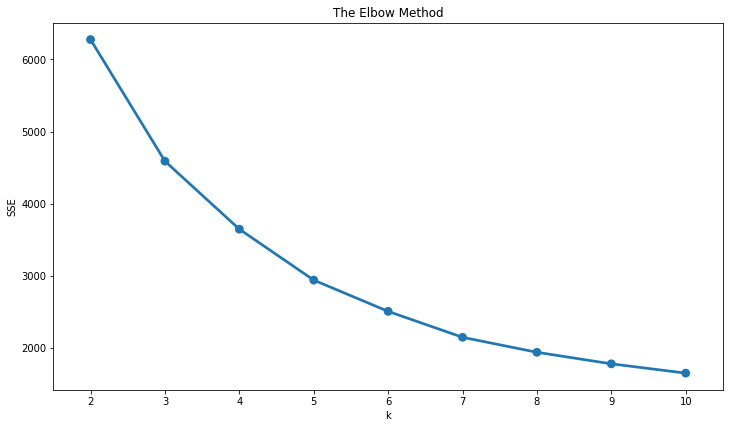

In [48]:
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel ('k')
plt.ylabel ('SSE')
sns.pointplot (x=list(sse.keys()), y=list(sse.values()))
plt.show()

Let's choose k=5

In [49]:
KMs = KMeans(n_clusters=5, random_state=27)
KMs.fit_transform(X)
KMs.labels_

array([0, 1, 3, ..., 4, 2, 3])

In [50]:
df_RFM['Cluster'] = KMs.labels_
silhouette_score(X, KMs.labels_)

0.33627214417573004

Basic statistics of each cluster:

In [51]:
df_RFM.iloc[:,1:].groupby('Cluster').agg({'mean','std','min','median','max'}).round(2)

Recency                        Frequency                         \
           mean min  max    std median      mean min  max    std median   
Cluster                                                                   
0        237.82  82  374  79.72  241.0      1.24   1    3   0.46    1.0   
1         15.48   1  303  24.80    9.0     20.21   4  246  21.66   15.0   
2         17.59   1   81  13.12   15.5      6.05   1   39   3.17    5.0   
3        107.38  27  367  63.25   86.0      3.83   1   20   1.94    3.0   
4         38.79   1   95  23.30   35.0      1.42   1    4   0.55    1.0   

        Monetary                                       
            mean      min       max      std   median  
Cluster                                                
0         285.32     3.75   2349.60   238.36   225.37  
1        6125.96  2499.57  12711.74  3088.19  4913.54  
2        1510.18    95.40   5774.35   764.91  1368.79  
3        1037.16    70.02   5930.32   720.48   815.97  
4         346.03     0.00   1600.00   231.78   298.40

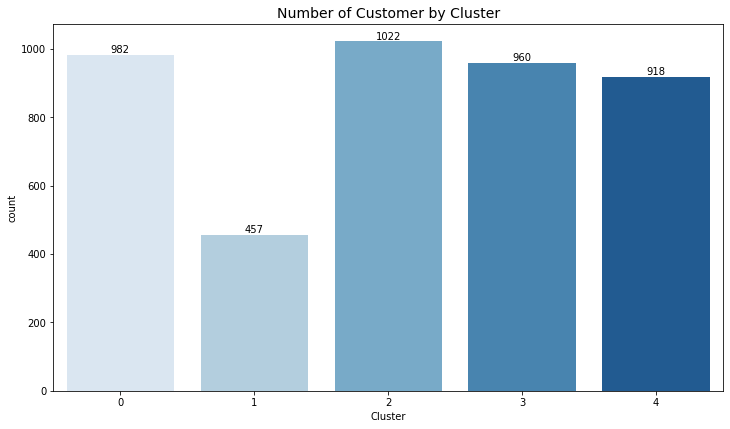

In [52]:
ax = sns.countplot(data=df_RFM, x='Cluster', palette='Blues')
ax.bar_label(ax.containers[0])
plt.title('Number of Customer by Cluster', size=14)
plt.show()

Visualize clusters with a sample of 500 entries

In [53]:
df_sample = df_RFM.sample(500, random_state=15)
trace1 = go.Scatter3d(
    x= df_sample.Recency,
    y= df_sample.Frequency,
    z= df_sample.Monetary,
    mode='markers',
    marker=dict(
        color = df_sample.Cluster, 
        size= 3,
        line=dict(color= df_sample.Cluster, width= 12),
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Recency'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Monetary')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Author
Truong Hong Thai